In [61]:
#!pip install pillow


In [62]:
from PIL import Image, ImageOps
import shutil
import os
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [63]:
# Parameters
input_train_folder = '../data/train_features'
input_test_folder = '../data/test_features'

middle_train_folder = '../data/temp/middle/train'
output_train_folder = '../data/temp/train'

middle_val_folder = '../data/temp/middle/val'
output_val_folder = '../data/temp/val'

middle_test_folder = '../data/temp/middle/test'
output_test_folder = '../data/temp/test'


label_csv = '../data/train_labels.csv'
output_label_csv = '../data/temp/train_labels_with_augm.csv'


low_classes = ['bird', 'hog']


use_padding = 1  # Set this to False if you do not want to apply padding
limit_width_before_padding=640 # gut values 960,640
output_width = 160 #960, 640, 160
output_height = 90 # 540, 360, 90
channels_number = 1  # 3 = RGB, 1 = black & white

# Model's default values
batch_size = 32
optimizer='adam'
epochs_number = 1

In [64]:
# if we want to reduse pictures to 640x360 for example before padding because the most pictures have this size
def max_sizes(input_folder,limit_width=None):
    max_width = 0
    max_height = 0
    # First, iterate through all images to find the maximum dimensions
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                if width > max_width:
                    max_width = width
                if height > max_height:
                    max_height = height
    if limit_width != None:
        max_height = int(round(max_height*limit_width/max_width,0))
        max_width = limit_width
    return max_width, max_height


# Define the range of white color
def is_white_color(color, threshold=230):
    # Check if color is close to white within the given threshold
    return all(c >= threshold for c in color)


# Adjust threshold based on what is considered "close to white"
def crop_white_bottom_from_image(img, check_hight=8, check_width=10, start_from=60, threshold=230):
    width, height = img.size
    # Define the region to check for white color
    box = (start_from, height - check_hight, start_from + check_width, height)
    region = img.crop(box)
    # Convert the region to a NumPy array for easy processing
    region_np = np.array(region)
    # Check if all pixels in the region are close to white
    white_pixels = np.apply_along_axis(is_white_color, 1, region_np)
    
    if np.all(white_pixels):
        # Crop the bottom 16 pixels
        img = img.crop((0, 0, width, height - check_hight - 8))
    return img


def padding_images(img,max_width,max_height):
    # Calculate padding required to center the image
    delta_width = max_width - img.width
    delta_height = max_height - img.height
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))
    # Add padding and create a new image with the desired size
    return ImageOps.expand(img, padding, fill=0)

def format_to_rgb(img):
    if img.mode != 'RGB':
        # Convert image to RGB
        img = img.convert('RGB')
    return img

def set_channel(image,channels_number):
    if channels_number == 3:
        return image
    else:
        # Convert RGB image to grayscale
        image = image.convert('L')
        #image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image

def reducing_width(img, max_width=640):
    if max_width:
        #Get the image dimensions
        width, height = img.size
        # If the image width is greater than 640, resize it
        if width > max_width:
            # Calculate the scaling factor
            scale_factor = max_width / width
            new_width = max_width
            new_height = int(height * scale_factor)
            # Resize the image
            img = img.resize((new_width, new_height), Image.LANCZOS)
    return img

def is_bright_orange(rgb):
    r, g, b = rgb
    # Approximate boundaries for bright orange color in RGB
    return (r > 180 and 50 < g < 200 and b < 110)

def replace_logo_with_neighboring_colors(img,search_area_height=50, search_area_width=50):
    #Get the image dimensions
    width, height = img.size
    pixels = img.load()

    # List to store coordinates of orange pixels
    orange_points = []

    # Iterate over the bottom-left 50x50 rectangle
    for x in range(search_area_width):
        for y in range(height - search_area_height, height):
            if is_bright_orange(pixels[x, y]):
                orange_points.append((x, y))
 
    # If orange pixels are found
    if orange_points:
        # Find the top-right orange point and take some points more
        max_orange_x = max(x for x,y in orange_points)+3
        min_orange_y = min(y for x,y in orange_points)-5

        # Replace logo with vertical lines. Color is like color of pixel above
        for x in range(max_orange_x):
            color = pixels[x, min_orange_y-1]
            for y in range(min_orange_y, height):
                pixels[x, y] = color
    return img



In [65]:
# Augmentation for birds and hogs

def augment_class_images(input_folder, train_df, target_classes):
    # Calculate the average number of images across all classes
    class_counts = train_df.drop(columns=['id']+target_classes).sum(axis=0)
    avg_count = int(class_counts.mean())

    # Create a generator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,       # Rotations
        width_shift_range=0.1,   # Width shifts
        height_shift_range=0.1,  # Height shifts
        shear_range=0.1,         # Shear angle shifts
        zoom_range=0.1,          # Zooming
        horizontal_flip=True,    # Horizontal flipping
        fill_mode='nearest'      # Filling new pixels after transformation
    )
    # Perform augmentation for each target class
    for target_class in target_classes:
        # Filter the dataframe for the target class
        class_df = df[df[target_class] == 1]
        # Calculate how many images need to be generated
        num_images_needed = avg_count - len(class_df)

        # Create output folder for the augmented images
        output_folder = os.path.join(input_folder, target_class)#f'{target_class}_augmented')

        # Check if the directory exists
        if os.path.exists(output_folder):
            #Delete the directory along with its contents
            shutil.rmtree(output_folder)

        os.makedirs(output_folder, exist_ok=True)
        for _ in range(num_images_needed): 
            random_id = class_df['id'].sample(n=1).iloc[0] 
            img_path = os.path.join(input_folder, random_id)
            img = load_img(img_path)
            x = img_to_array(img)  # Convert image to numpy array
            x = x.reshape((1,) + x.shape)  # Add dimension to work with ImageDataGenerator
            # Generate new images
            for batch in datagen.flow(x, batch_size=1,save_to_dir=output_folder, save_prefix=target_class, save_format='jpeg'):
                break
           
           
        print(f"Created {num_images_needed} augmented images for class '{target_class}' in folder '{output_folder}'.")




In [66]:
def preprocessing_features(input_folder,output_folder,input_df=None,limit_width=None):
    # Limit_width: None if we want to have maximal width 960, the most common 640
    max_width, max_height = max_sizes(input_folder,limit_width)

    # Check if the directory exists
    if os.path.exists(output_folder):
        #Delete the directory along with its contents
        shutil.rmtree(output_folder)
    # Create the new folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through each image in the source folder
    if input_df is not None and not input_df.empty:
        file_list = input_df['id']
    else:
        file_list = os.listdir(input_folder)
        #file_list = file_list.apply(lambda x: os.path.join(input_folder, x))
        
    for filename in file_list:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                img = format_to_rgb(img)
                img = crop_white_bottom_from_image(img)
                img = replace_logo_with_neighboring_colors(img)
                #img =  reducing_width(img,limit_width)
                #img = padding_images(img,max_width,max_height)
                # Save the image to the new folder
                new_file_path = os.path.join(output_folder, filename)
                img.save(new_file_path)
    print(output_folder, "Prerocessing complete.")

def processing_features(input_folder,output_folder,target_classes=[],limit_width=None,use_padding=True,output_width=None,output_height=None,channels_number=1):
    # Limit_width: None if we want to have maximal width 960, the most common 640
    max_width, max_height = max_sizes(input_folder,limit_width)
    

    # List to store new rows
    new_rows = []
    # Only train_folder can have subfolders with augmented classes
    input_folder_has_subfolders = any(os.path.isdir(os.path.join(input_folder, item)) for item in os.listdir(input_folder))
    

    # Create the new folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through each image in the source folder
    for dirpath, dirnames, filenames in os.walk(input_folder):
        for filename in filenames:
             # Get the file name without extension
            file_name_no_ext = os.path.splitext(filename)[0]
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(dirpath, filename)
                with Image.open(file_path) as img:
                    img =  set_channel(img,channels_number)
                    if use_padding:
                        img =  reducing_width(img,limit_width)
                        img = padding_images(img,max_width,max_height)
                    img = img.resize((output_width, output_height), Image.LANCZOS)
                    # Save the image to the new folder
                    new_file_path = os.path.join(output_folder, filename)
                    img.save(new_file_path)

            if input_folder_has_subfolders:
                for target in target_classes:        
                    if target in os.path.relpath(dirpath, input_folder).split(os.sep):
                        # Create a new row with zeros
                        new_row = {col: 0 for col in df_csv.columns}
                        # Fill in the data in the row
                        new_row['id'] = file_name_no_ext
                        new_row[target] = 1
                        # Add the new row to the list
                        new_rows.append(new_row)
    
    
    # Convert the list of new rows to a DataFrame and concatenate it with the original DataFrame
    df_new_rows = pd.DataFrame(new_rows)
    

    print(output_folder, "Processing complete.")
    
    return df_new_rows
        


In [67]:
# Load labels from CSV
df = pd.read_csv(label_csv)
class_names = list(df.columns[1:])

frac = 1.0

df = df.sample(frac=frac, random_state=1)


# Add a full path to each image in the dataframe
df['id'] = df['id'].apply(lambda x: x+'.jpg')#os.path.join(input_train_folder, x+'.jpg'))
#df['id'] = df['id'].apply(lambda x: x+'.jpg')#os.path.join(dataset_folder, x+'.jpg'))

# Perform stratified split based on the labels
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[df.columns[1:]])



preprocessing_features(input_train_folder, middle_train_folder, train_df)
preprocessing_features(input_train_folder, middle_val_folder, val_df)
preprocessing_features(input_test_folder, middle_test_folder)


#augment_class_images(middle_train_folder, train_df, low_classes)

df_low_augm = processing_features(middle_train_folder,output_train_folder,low_classes,\
                                  limit_width_before_padding,use_padding,output_width,output_height,channels_number)
train_df = pd.concat([train_df, df_low_augm], ignore_index=True)

processing_features(middle_val_folder,output_val_folder,low_classes,\
                                  limit_width_before_padding,use_padding,output_width,output_height,channels_number)
processing_features(middle_test_folder,output_test_folder,low_classes,\
                                  limit_width_before_padding,use_padding,output_width,output_height,channels_number)



../data/temp/middle/train Prerocessing complete.
../data/temp/middle/val Prerocessing complete.
../data/temp/middle/test Prerocessing complete.
../data/temp/train Processing complete.
../data/temp/val Processing complete.
../data/temp/test Processing complete.


""


In [68]:
train_df

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ008892.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,ZJ014951.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ZJ012958.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ014057.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ZJ010574.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
13185,ZJ001396.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13186,ZJ001772.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13187,ZJ006320.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13188,ZJ008909.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Found 13190 validated image filenames.
Found 3298 validated image filenames.


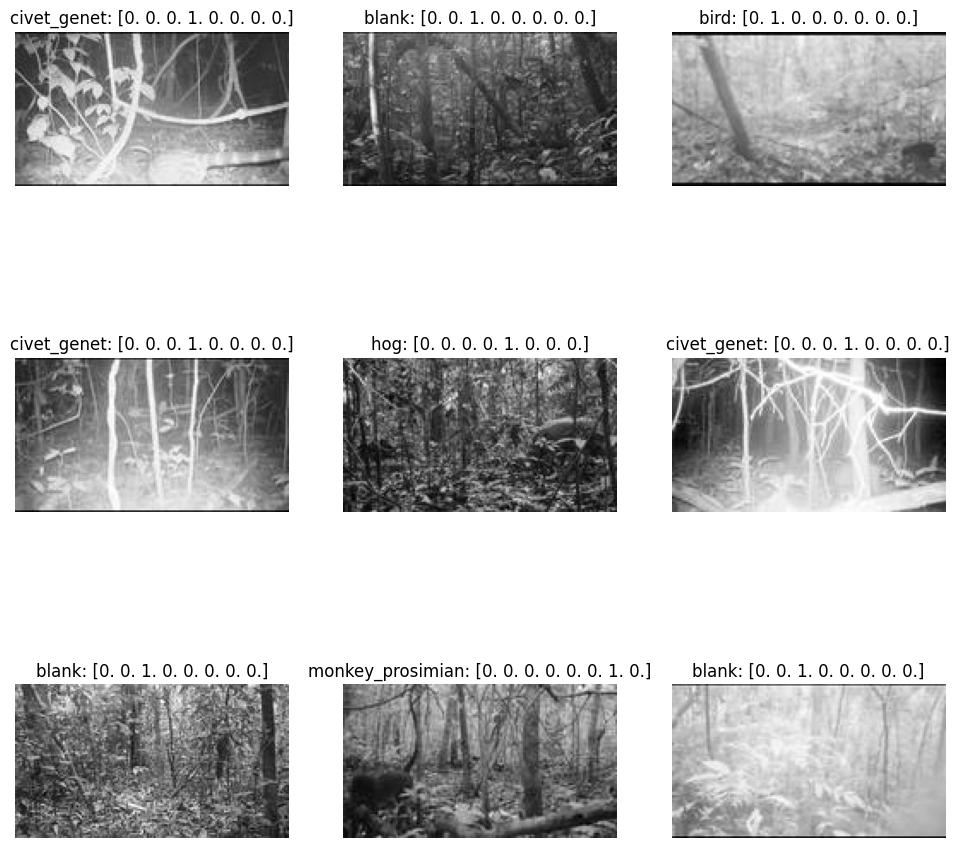

In [69]:
train_df2 = train_df.copy()
val_df2 = val_df.copy()
train_df2['id'] = train_df2['id'].apply(lambda x: os.path.join(output_train_folder, x))
val_df2['id'] = val_df2['id'].apply(lambda x: os.path.join(output_val_folder, x))

# Choose 'grayscale' for 1 channel (black & white) or 'rgb' for 3 channels
color_mode = 'grayscale' if channels_number == 1 else 'rgb'  # Set to 'rgb' or 'grayscale' based on the number of channels

# Data generator
datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
# Create the training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df2,
    directory=None,
    x_col='id',
    y_col=train_df2.columns[1:],  # All columns except 'ID' are labels
    target_size=(output_height, output_width),
    batch_size=batch_size,
    class_mode='raw',
    color_mode=color_mode  # Specify the color mode for the images
)
# Create the validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df2,
    directory=None,
    x_col='id',
    y_col=val_df2.columns[1:],
    target_size=(output_height, output_width),
    batch_size=batch_size,
    class_mode='raw',
    color_mode=color_mode  # Specify the color mode for the images
)



# Example: Display a batch of images and labels
images, labels = next(train_generator)  # Get a batch of images and labels
plt.figure(figsize=(12, 12))
for i in range(9):  # Display first 9 images
    index = np.argmax(labels[i])
    animal_name = class_names[index]
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"{animal_name}: {labels[i]}")
    plt.axis('off')
plt.show()

In [70]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(output_height, output_width, channels_number)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(len(train_df.columns) - 1, activation='softmax')  # Output layer for multi-label classification
])
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
# Train the model
history1 = model.fit(train_generator, validation_data=val_generator, epochs=epochs_number)
history1

413/413 [==============================] - 11s 26ms/step - loss: 1.8040 - accuracy: 0.3176 - val_loss: 1.6367 - val_accuracy: 0.3696


In [71]:
batch_size = 32
optimizer='adam'
epochs_number = 20

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(output_height, output_width, channels_number)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(train_df.columns) - 1, activation='softmax')  # Output layer for multi-label classification
])
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
# Train the model
history2 = model.fit(train_generator, validation_data=val_generator, epochs=epochs_number)
history2

Epoch 1/20
413/413 [==============================] - 12s 27ms/step - loss: 1.5878 - accuracy: 0.4064 - val_loss: 1.3791 - val_accuracy: 0.5115
Epoch 2/20
413/413 [==============================] - 10s 24ms/step - loss: 1.1474 - accuracy: 0.6045 - val_loss: 1.1019 - val_accuracy: 0.6401
Epoch 3/20
413/413 [==============================] - 10s 24ms/step - loss: 0.9087 - accuracy: 0.6908 - val_loss: 0.9689 - val_accuracy: 0.6743
Epoch 4/20
413/413 [==============================] - 10s 24ms/step - loss: 0.7757 - accuracy: 0.7353 - val_loss: 0.9842 - val_accuracy: 0.6637
Epoch 5/20
413/413 [==============================] - 10s 25ms/step - loss: 0.6769 - accuracy: 0.7710 - val_loss: 0.8527 - val_accuracy: 0.7244
Epoch 6/20
413/413 [==============================] - 10s 24ms/step - loss: 0.6047 - accuracy: 0.7967 - val_loss: 0.7641 - val_accuracy: 0.7583
Epoch 7/20
413/413 [==============================] - 10s 23ms/step - loss: 0.5728 - accuracy: 0.8074 - val_loss: 0.7387 - val_accuracy:

In [ ]:
"""model.save('../models/firstCNNmodel')"""

In [72]:
# # Load the saved model
# with tf.device('/cpu:0'):
#     new_model = tf.keras.models.load_model('../models/firstCNNmodel')

# # Check its architecture
# new_model.summary()

104/104 [==============================] - 1s 8ms/step


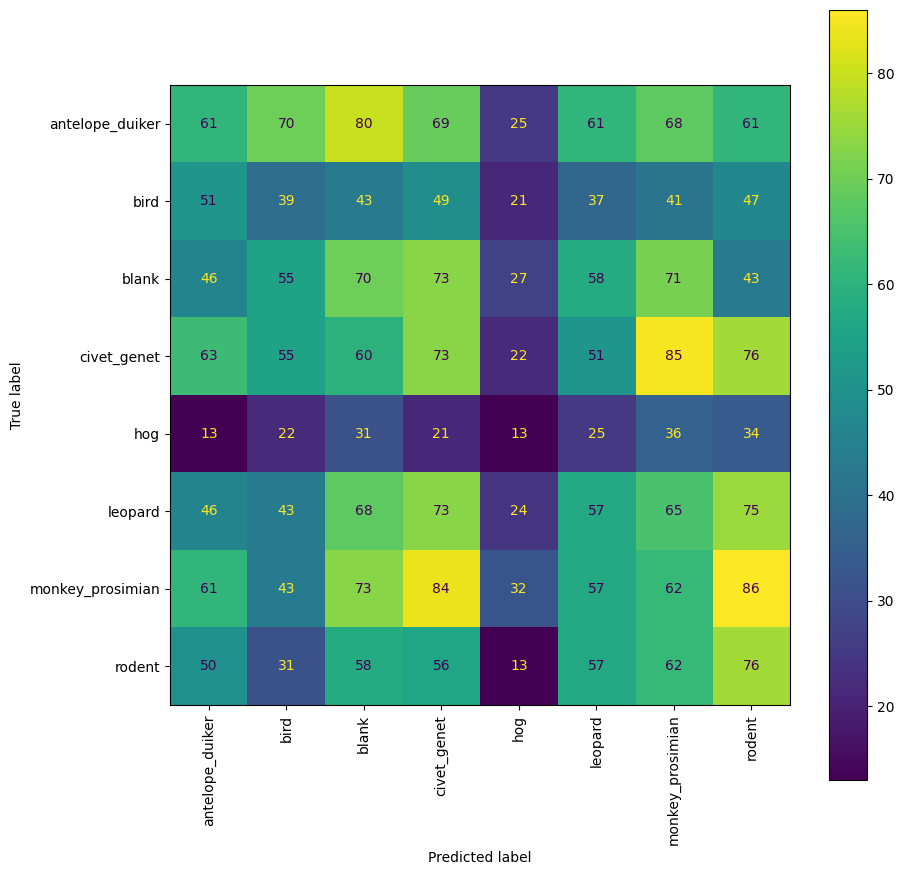

In [73]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get Predictions on Validation Data
val_preds = model.predict(val_generator)

# Convert predictions to binary format
# Identify index with highest value and set that entry to 1, all others to 0
val_preds_binary = np.zeros_like(val_preds)
val_preds_binary[np.arange(len(val_preds)), np.argmax(val_preds, axis=1)] = 1

# Step 2: Get True Labels
# Extract true labels from the validation generator
# Ensure true labels are in binary format, similar to val_preds_binary
val_true_labels = np.array(val_generator.labels)
# If labels are not binary, you might need to convert them
val_true_labels_binary = np.zeros_like(val_true_labels)
val_true_labels_binary[np.arange(len(val_true_labels)), np.argmax(val_true_labels, axis=1)] = 1

# Manually specify class labels
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']  # Adjust as necessary

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(val_true_labels_binary, axis=1), np.argmax(val_preds_binary, axis=1))

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax, xticks_rotation=90, colorbar=True)
plt.show()